In [1]:
%matplotlib notebook
import mygrad as mg

In [2]:
from cogworks_data.language import get_data_path

from pathlib import Path
import json

# load COCO metadata
filename = get_data_path("captions_train2014.json")
with Path(filename).open() as f:
    coco_data = json.load(f)

In [3]:
import pickle
with Path(get_data_path('resnet18_features.pkl')).open('rb') as f:
    resnet18_features = pickle.load(f)

In [4]:
# imports which aren't yet here because I'm lazy

In [5]:
from mynn.layers.dense import dense
from mygrad.nnet.initializers import glorot_normal
import numpy as np

class Model():
    """
    Model that creates semantic space embeddings using the original image vectors
    """
    def __init__(self, input_dim, output_dim, stored_weights=None):
        """ 
        Initializes the layer
        
        Parameters
        ----------
        dim_input: int 
            The original image descriptor vector dimension
        
        dim_output: int
            The final image embedding dimension
        """
        self.dense_layer = dense(input_dim, output_dim, weight_initializer=glorot_normal, bias=False)
        if stored_weights is not None:
            self.dense_layer.weight = mg.astensor(stored_weights)
    def __call__(self, x):
        """
        Does one forward pass of the network
        
        Parameters
        ----------
        x: Union[numpy.ndarray, mygrad.Tensor], shape=(training data length, input_dim)
            The training data of image descriptor vectors
        
        Returns
        -------
        mygrad.Tensor, shape=(training data length, output_dim)
            The normalized image embeddings predicted by the model
        """
        embeddings = self.dense_layer(x)
        magnitude = np.linalg.norm(embeddings, axis=1, keepdims=True)
        
        return embeddings / magnitude
        
    @property
    def parameters(self):
        """
        Gets the model's parameters
        
        Returns
        -------
        Tuple[Tensor, ...]
            The weights of the model
        """
        return self.dense_layer.parameters

In [6]:
def load_weights():
    """ 
        Loads the weights from the numpy array file
        
        Returns
        -------
        The array of weights
        """
    return np.load('WeightsArray.npy')

def save_weights(arr: np.array):
    """ 
        Stores the weights to the numpy array file
        
        Parameters
        ----------
        arr: np.array
            The array of weights
        """
    np.save('WeightsArray.npy', arr)

<IPython.core.display.Javascript object>


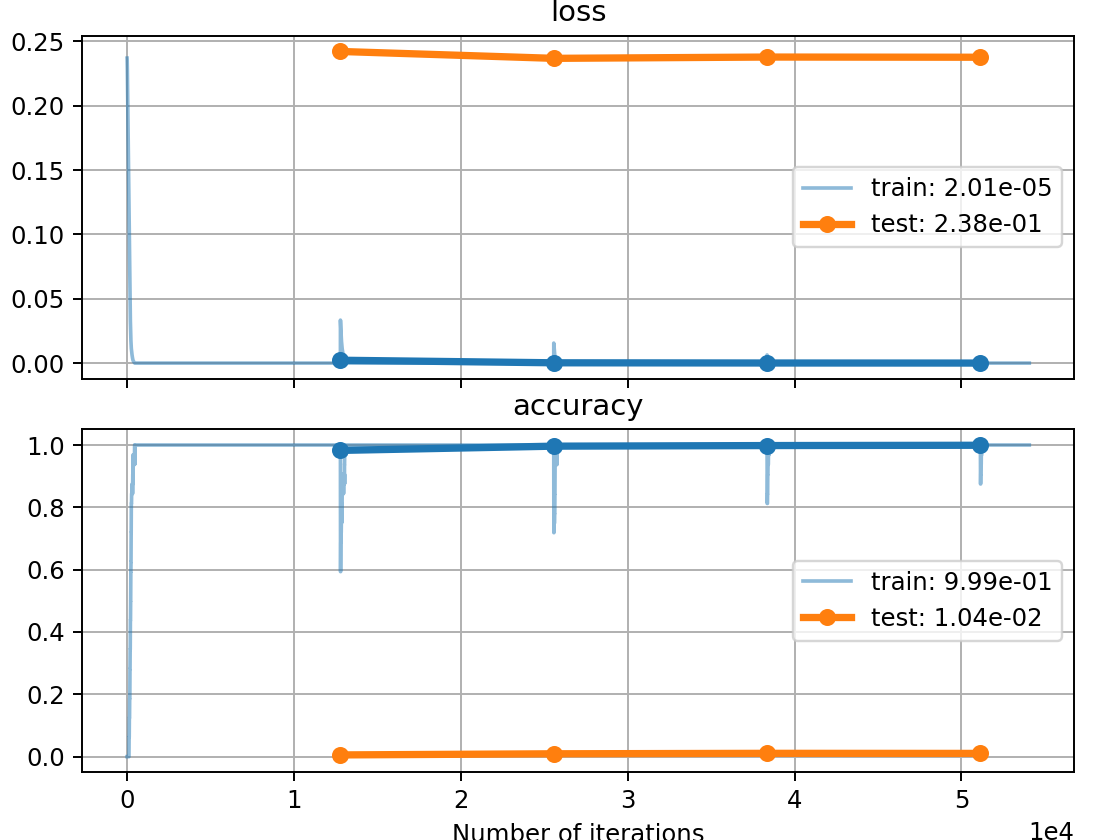

In [65]:
import matplotlib.pyplot as plt
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

In [15]:
from mynn.optimizers.sgd import SGD
from OmniCog import CocoDataManager, train_split, extract_triples
from OmniCog import margin_loss

In [9]:
# only run if we actually stored weights to use, need this cell for testing
model2 = Model(512, 200, load_weights())

In [9]:
manager = CocoDataManager(coco_data, resnet18_features)

In [66]:
model = Model(512, 200)
optimizer = SGD(model.parameters, learning_rate = 1e-3, momentum=0.9)

epochs = 10
batch_size = 32

testing, training = train_split(manager.imageIDs, validation=0.01)
# print(len(training), len(testing))
print(len(training)/batch_size)

for iteration in range(0, epochs):
    training_data = extract_triples(manager, training, validation=True)
    # creates a shuffled array of training indices
    indices = np.arange(len(training_data))
#     np.random.shuffle(indices)
    
    # trains the model by improving the loss and accuracy metrics for the training data in batches
    for batch_count in range(0, len(training_data)//batch_size):
#     for batch_count in np.zeros(len(training_data)//batch_size):
#         batch_indices = indices[batch_count * batch_size : (batch_count+1) * batch_size]
        batch_indices = indices[0 : 32]
        batch = training_data[batch_indices]
        
        true_x = np.array([resnet18_features[true_vec][0] for (true_vec, _, _) in batch])
        conf_x = np.array([resnet18_features[confuse_vec][0] for (_, _, confuse_vec) in batch])
        
        
        true_embedding = model(true_x)
        confuser_embedding = model(conf_x)
        
        caption_embedding = [manager.captionID_to_captionEmbedding[captionid] for (_, captionid, _) in batch]
        caption_embedding = np.array(caption_embedding)
        
        loss, truesim, confusesim = margin_loss(true_embedding, caption_embedding, confuser_embedding)
        accuracy = (truesim > (confusesim + 0.25)).mean()
        
        loss.backward()
        optimizer.step()
        
        plotter.set_train_batch({"loss":loss.item(), "accuracy":accuracy}, batch_size=batch_size, plot=True)
    # creates a shuffled array of training indices  
    testing_data = extract_triples(manager, testing, validation=True)
    test_indices = np.arange(len(testing_data))
    np.random.shuffle(test_indices)
    
    with mg.no_autodiff:
        # calculates the loss and accuracy for the validation data in batches
        for batch_count in range(0, len(testing_data)//batch_size):
            test_batch_indices = test_indices[batch_count * batch_size : (batch_count+1) * batch_size]
            test_batch = testing_data[test_batch_indices]

            true_x = np.array([resnet18_features[true_vec][0] for (true_vec, _, _) in test_batch])
            conf_x = np.array([resnet18_features[confuse_vec][0] for (_, _, confuse_vec) in test_batch])

            true_embedding = model(true_x)
            confuser_embedding = model(conf_x)

            caption_embedding = [manager.captionID_to_captionEmbedding[captionid] for (_, captionid, _) in test_batch]
            caption_embedding = np.array(caption_embedding)

#             test_loss = margin_loss(true_embedding, caption_embedding, confuser_embedding)
#             test_accuracy = batch_accuracy(loss)
#             test_avg_loss = np.mean(loss)
            test_loss, test_truesim, test_confusesim = margin_loss(true_embedding, caption_embedding, confuser_embedding)
            test_accuracy = (test_truesim > (test_confusesim + 0.25)).mean()

            plotter.set_test_batch({"loss":test_loss.item(), "accuracy":test_accuracy}, batch_size=batch_size)
    
    # plots the loss and accuracy in each epoch
#     print(iteration)
    plotter.set_train_epoch()
    plotter.set_test_epoch()

# stores the final weights in a file
save_weights(model.parameters)

2555.8125


KeyboardInterrupt: 